In [2]:
# Importing SHAP for model interpretation
import shap

# Importing scikit-learn for machine learning tools
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os

In [4]:
%matplotlib inline

In [5]:
import sklearn
print("SHAP version:", shap.__version__)
print("Scikit-learn version:", sklearn.__version__)

SHAP version: 0.46.0
Scikit-learn version: 1.2.2


In [6]:
# Load dataset
df = pd.read_csv('./data/df_clean.csv')
df.head()

,Tuition,FRP_Active,FRP_Cancelled,FRP_Take_up_percent_,EZ_Pay_Take_Up_Rate,School_Sponsor,SPR_Group_Revenue,FPP_to_PAX,Num_of_Non_FPP_PAX,ID_TRIP,...,Cancellation_Rate,Revenue_per_PAX,Deposit_Ratio,Insurance_Cancellation_Rate,Months_to_Departure,Past_Bookings,Initial_Year,Initial_Season,Grade_Span,Departure_Season
0,397,1,1,0.020913,0.017856,1,447,0.967036,2,1389,...,0.096774,7.982143,7.089286,1.000000,6,40.0,2018,1,1.0,2
1,563,0,0,0.600876,0.217302,0,579,0.993127,1,3090,...,0.000000,13.159091,12.795455,0.181818,5,89.0,2018,2,0.0,2
2,617,0,0,0.600876,0.217302,0,529,0.973946,1,3639,...,0.000000,11.020833,12.854167,0.181818,6,92.0,2018,2,0.0,2
3,446,1,1,0.019032,0.019285,1,381,0.981972,2,4249,...,0.107143,7.620000,8.920000,1.000000,7,26.0,2018,1,1.0,2
4,582,15,11,0.597237,0.035036,1,596,0.963426,2,1021,...,0.500000,24.833333,24.250000,0.733333,6,65.0,2018,1,0.0,2


In [7]:
# Dummies
df = pd.get_dummies(df, columns = ['Program_Code'], drop_first=True)
df['Group_State_encoded'] = df['Group_State'].map(df['Group_State'].value_counts(normalize=True))
df = df.drop(columns=['Group_State'])
df = pd.get_dummies(df, columns=['Travel_Type'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['SPR_Product_Type'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['MajorProgramCode'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['Region'], dtype=int, drop_first=True)
df = pd.get_dummies(df, columns=['School_Type'], dtype=int, drop_first=True)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train Test split

target = "Retained"  

# Keep Only Numeric Features (Remove categorical variables such IDs)
df_clean = df.select_dtypes(include=['number']).copy()

# Define Features (X) and Target (y)
X = df_clean.drop(columns=[target])
y = df_clean[target]

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Load the model

# Create the full file path
save_folder = './saved_models/models05'
model_filename = 'forest05.pkl'
file_path = os.path.join(save_folder, model_filename)

with open(file_path, 'rb') as f:
    model = pickle.load(f)


In [10]:
# Create an explainer for the RandomForest
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the training dataset
shap_values = explainer.shap_values(X_train)

In [ ]:
# Save the SHAP values to a pickle file
with open("shap_values05.pkl", "wb") as f:
    pickle.dump(shap_values, f)

In [11]:
print(type(shap_values))
if isinstance(shap_values, list):
    print("Number of classes (elements in list):", len(shap_values))
    for i, arr in enumerate(shap_values):
        print(f"Shape of shap_values for class {i}:", arr.shape)
else:
    print("Shape of shap_values:", shap_values.shape)

<class 'numpy.ndarray'>
Shape of shap_values: (3300, 65, 2)


When creating plots like the summary plot, you need to decide which class's SHAP values you want to visualize. For a binary classification problem, a common practice is to focus on the positive class (index 1).

In [ ]:
# shap_values.values has shape (3300, 65, 2)
# To plot for the positive class (class index 1), do:
positive_class_shap = shap_values[:, :, 1]

# NB positive class is Target = 1 i.e. Retained = 1 (the customer confirms the trip also for the following year)

# Test

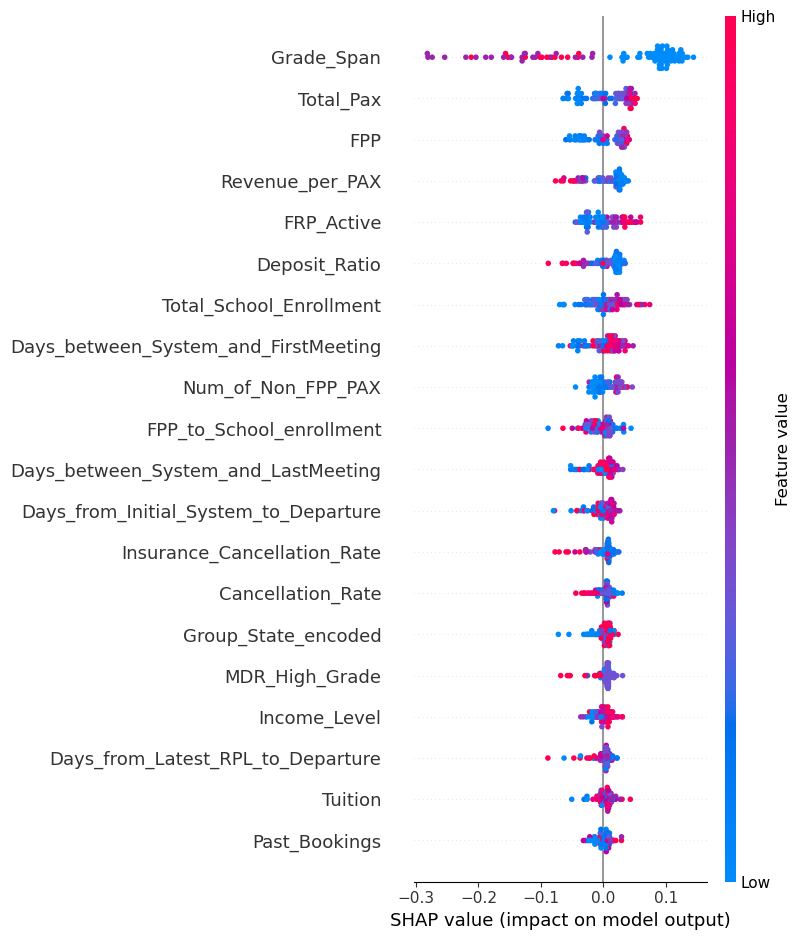

In [19]:
# Define a subset of samples (e.g., the first 100 samples)
subset = slice(0, 100)

# If your shap_values is an Explanation object,
# extract the values for the positive class (class index 1)
positive_class_shap_subset = shap_values[subset, :, 1]

# Also slice your data accordingly
X_train_subset = X_train.iloc[subset, :]

# Now plot the summary plot for the subset
shap.summary_plot(positive_class_shap_subset, X_train_subset)

# SHAP Summary Plot

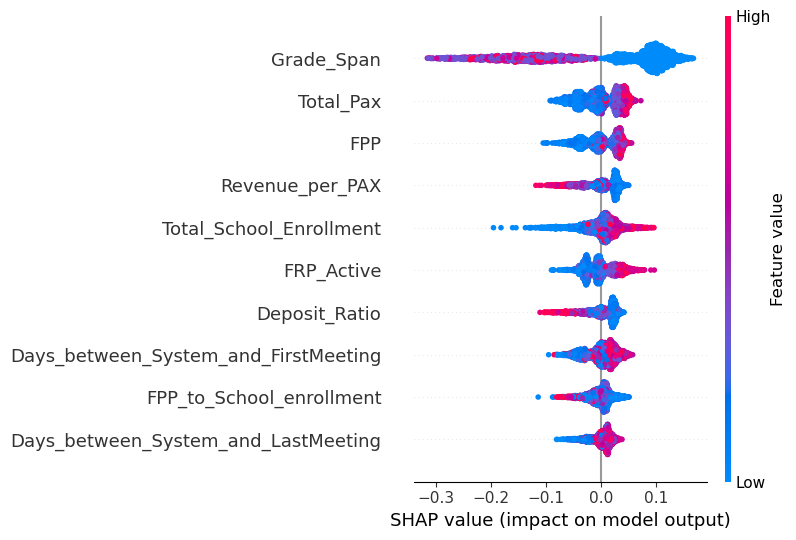

In [27]:
# Plot the SHAP values for the positive class (e.g., class 1)
shap.summary_plot(
    shap_values[:, :, 1],  # SHAP values (samples, features) for class 1
    X_train,               # Corresponding data
    plot_type="dot",       # Default: beeswarm plot
    max_display=10         # Show top 10 features
)

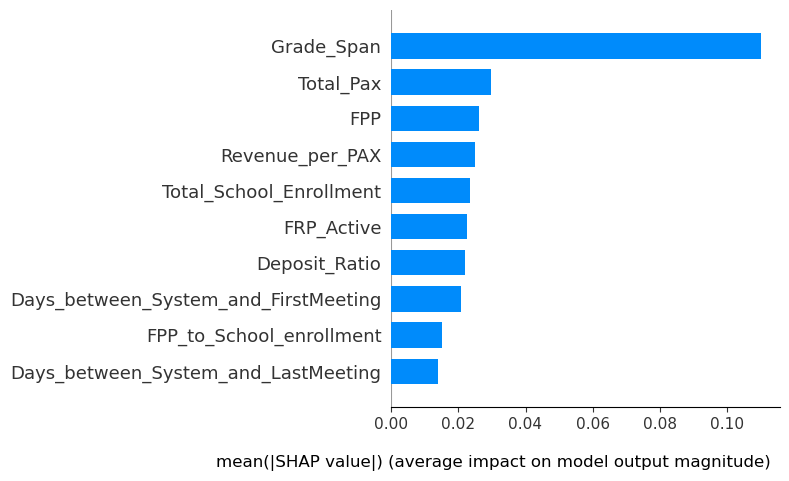

In [55]:
# Generate the SHAP bar plot without auto-show
shap.summary_plot(
    shap_values[:, :, 1],
    X_train,
    plot_type="bar",
    max_display=10,
    show=False
)

# Grab current axis
ax = plt.gca()

# Set x-axis label normally but override position
xlabel = "mean(|SHAP value|) (average impact on model output magnitude)"
ax.set_xlabel(xlabel, fontsize=12, ha='left')

# Now manually shift the label to far left under the y-axis ticks
# Use a small y offset to prevent overlap
ax.xaxis.set_label_coords(-0.45, -0.12)  # x from 0 to 1 (left to right), y < 0 lowers it

# Optional: adjust spacing to avoid clipping
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

# Show final result
plt.show()


# Dependece plot

## With strong feature

Plotting 1/10: Grade_Span


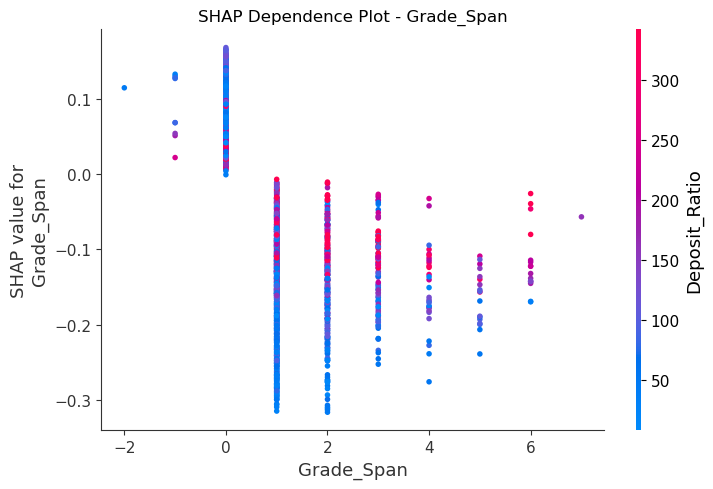

Plotting 2/10: Total_Pax


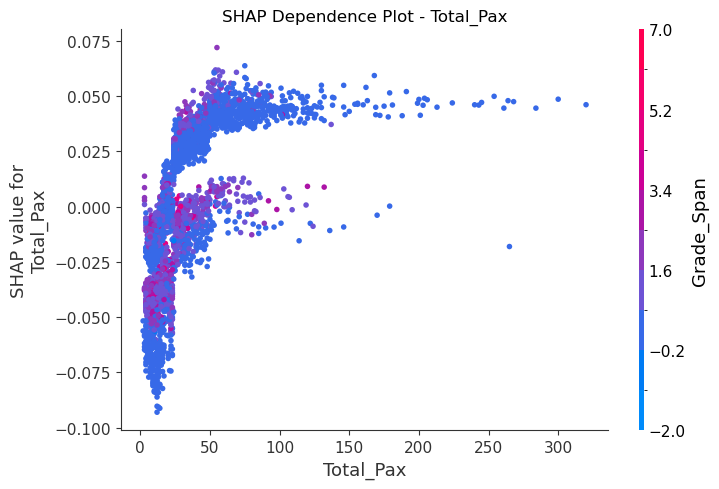

Plotting 3/10: FPP


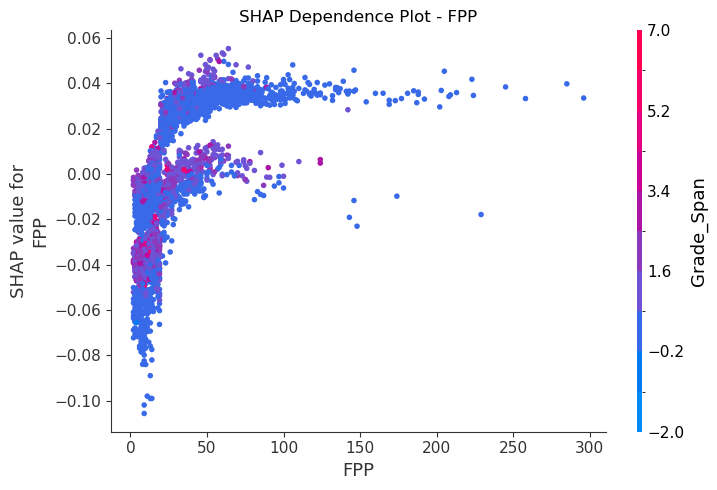

Plotting 4/10: Revenue_per_PAX


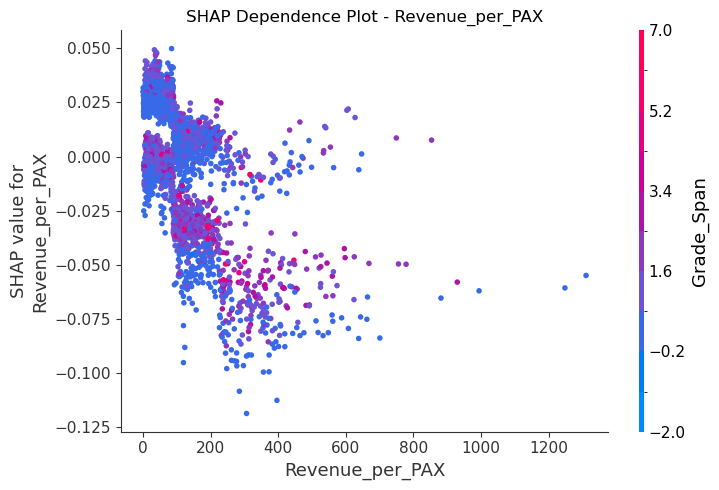

Plotting 5/10: Total_School_Enrollment


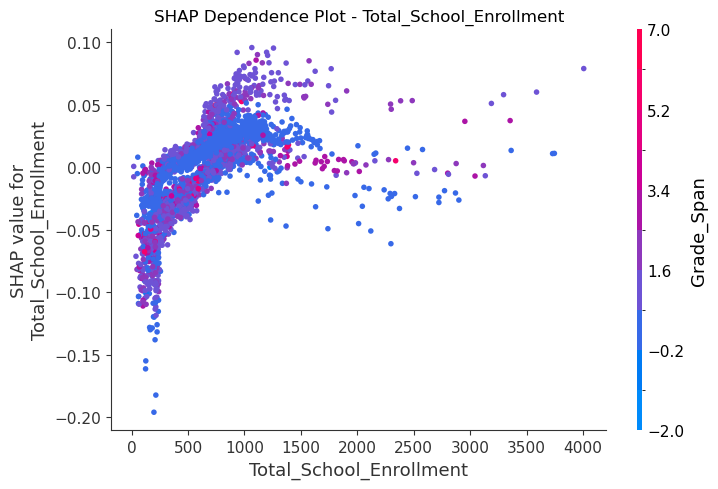

Plotting 6/10: FRP_Active


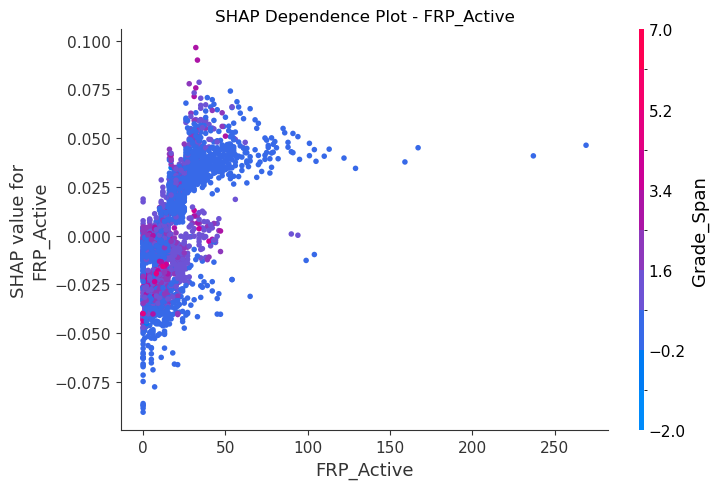

Plotting 7/10: Deposit_Ratio


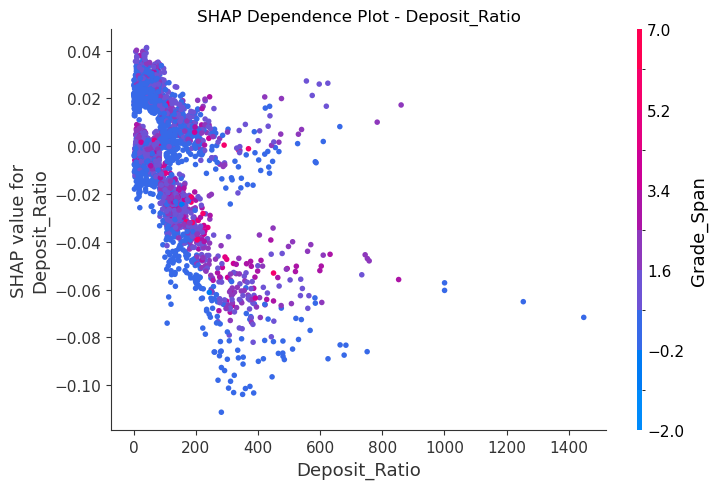

Plotting 8/10: Days_between_System_and_FirstMeeting


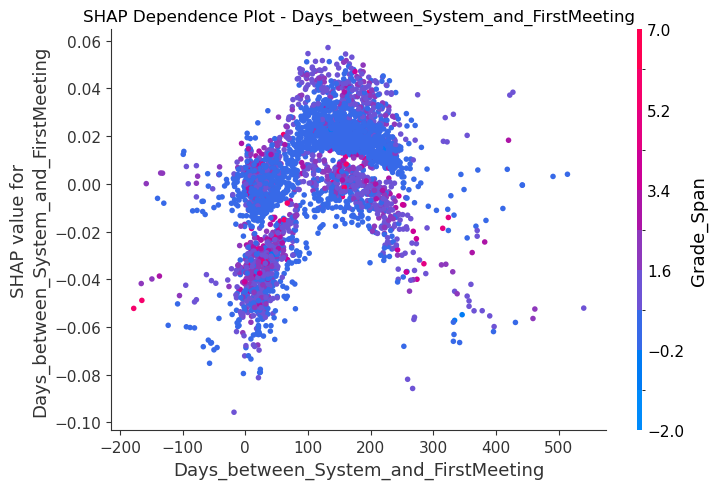

Plotting 9/10: FPP_to_School_enrollment


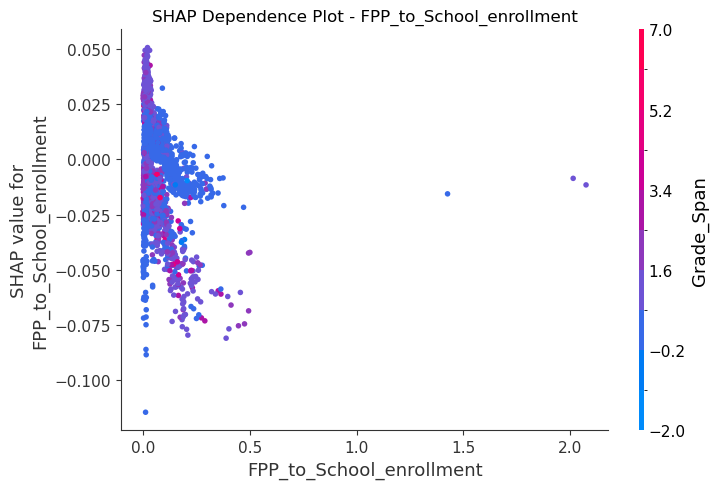

Plotting 10/10: Days_between_System_and_LastMeeting


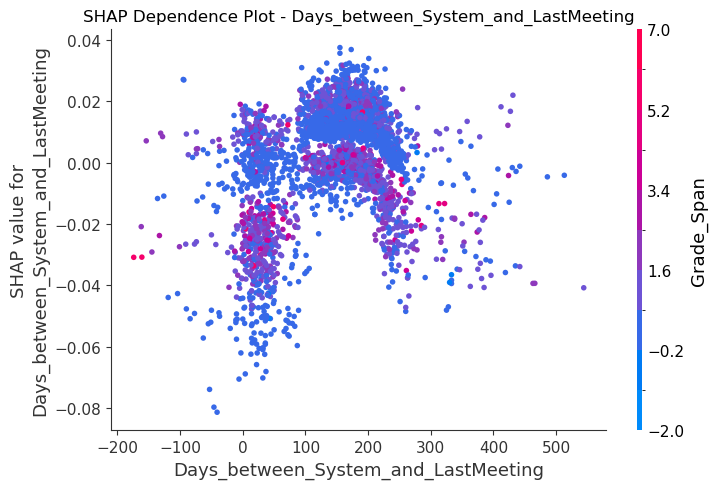

In [40]:
# Step 1: Extract SHAP values for positive class
shap_class_1 = shap_values[:, :, 1]

# Step 2: Compute mean absolute SHAP values
mean_abs_shap = np.abs(shap_class_1).mean(axis=0)

# Step 3: Get top 10 most important features
top_10_indices = np.argsort(mean_abs_shap)[::-1][:10]
top_10_features = X_train.columns[top_10_indices]

# Step 4: Generate dependence plots
for i, feature_name in enumerate(top_10_features):
    print(f"Plotting {i+1}/10: {feature_name}")
    fig = shap.dependence_plot(
        feature_name,
        shap_class_1,
        X_train,
        feature_names=X_train.columns,
        show=False  # Prevent SHAP from auto-showing the plot
    )
    plt.title(f"SHAP Dependence Plot - {feature_name}")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

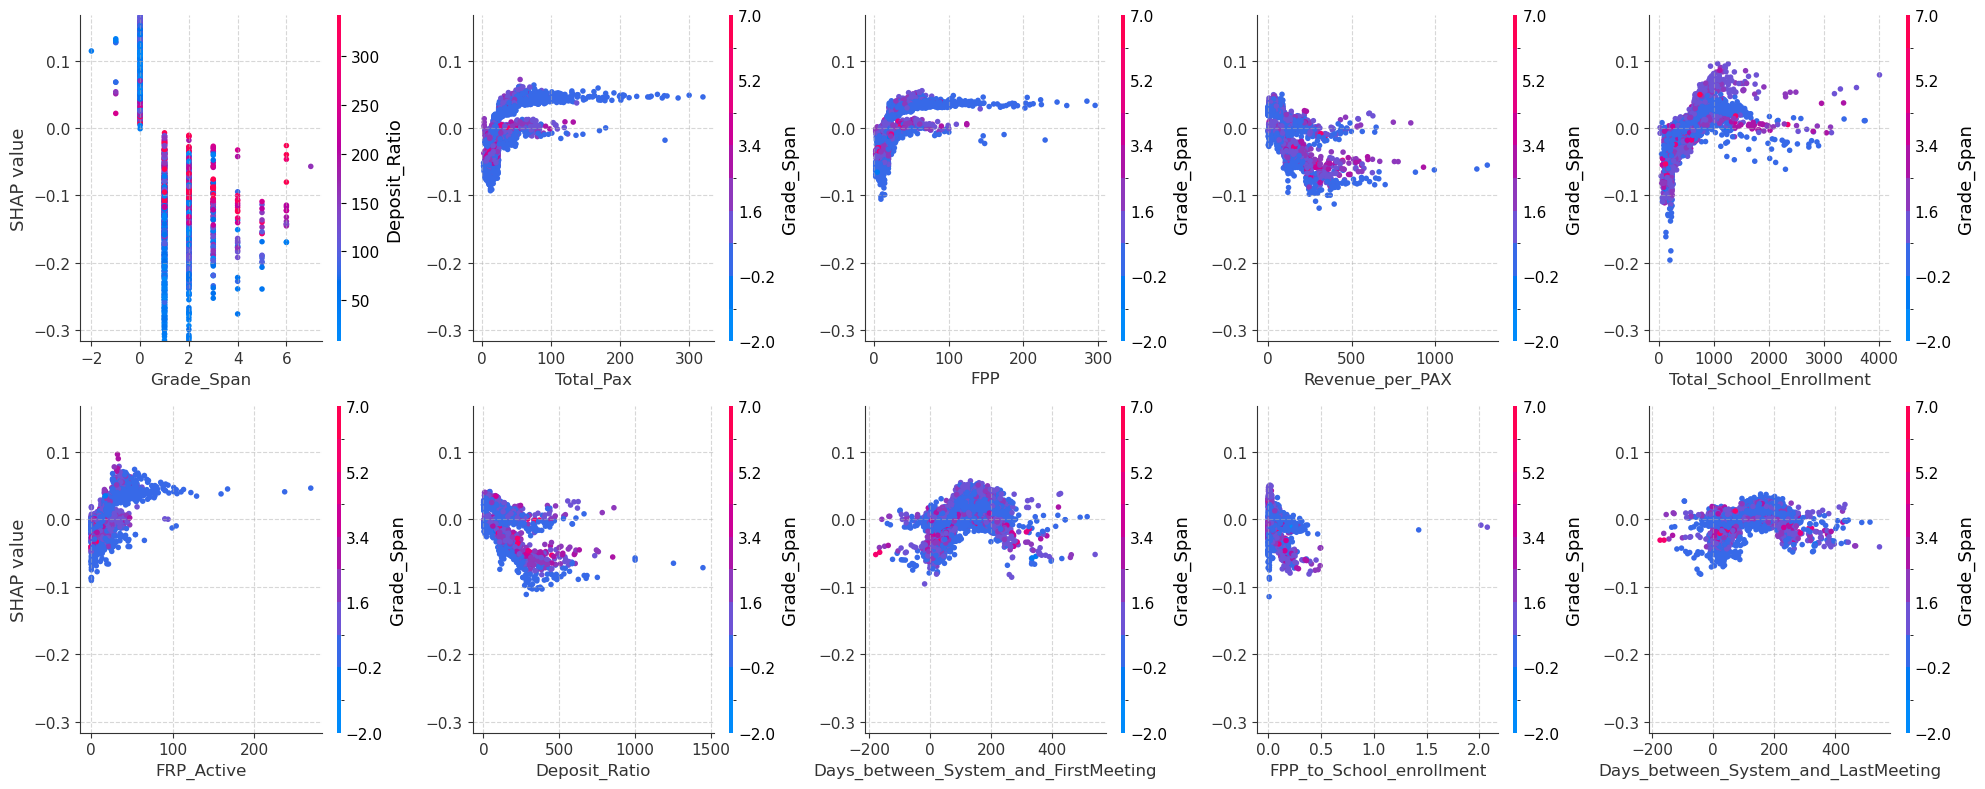

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# Use SHAP values for the positive class (e.g., class 1)
shap_class_1 = shap_values[:, :, 1]

# Get top 10 features by mean absolute SHAP value
mean_abs_shap = np.abs(shap_class_1).mean(axis=0)
top_10_indices = np.argsort(mean_abs_shap)[::-1][:10]
top_10_features = X_train.columns[top_10_indices]

# Get global SHAP value limits for consistent y-axis across plots
shap_min = shap_class_1[:, top_10_indices].min()
shap_max = shap_class_1[:, top_10_indices].max()

# Create 2x5 grid for plotting
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for i, feature_name in enumerate(top_10_features):
    ax = axes[i]

    # Plot SHAP dependence plot with automatic interaction coloring
    shap.dependence_plot(
        feature_name,
        shap_class_1,
        X_train,
        feature_names=X_train.columns,
        interaction_index='auto',  # Color by most interacting feature
        ax=ax,
        show=False
    )

    # Customize plot appearance
    ax.set_xlabel(feature_name, fontsize=12)
    ax.set_title("")  # No title
    ax.set_ylim([shap_min, shap_max])
    ax.grid(True, linestyle='--', alpha=0.5)

    if i % 5 == 0:
        ax.set_ylabel("SHAP value")
    else:
        ax.set_ylabel("")

# Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()


## Without strong feature

Plotting 1/10: Grade_Span


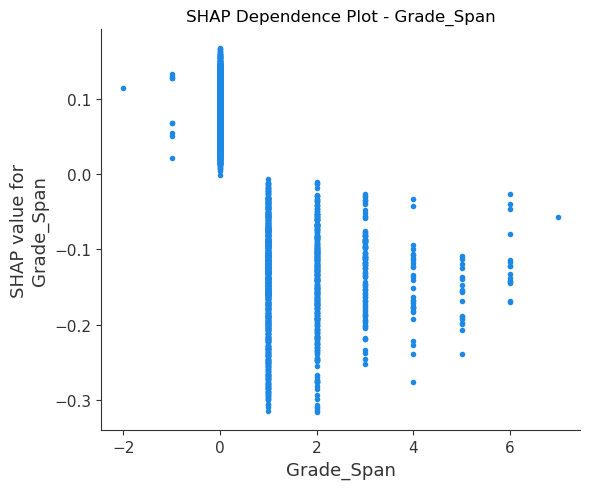

Plotting 2/10: Total_Pax


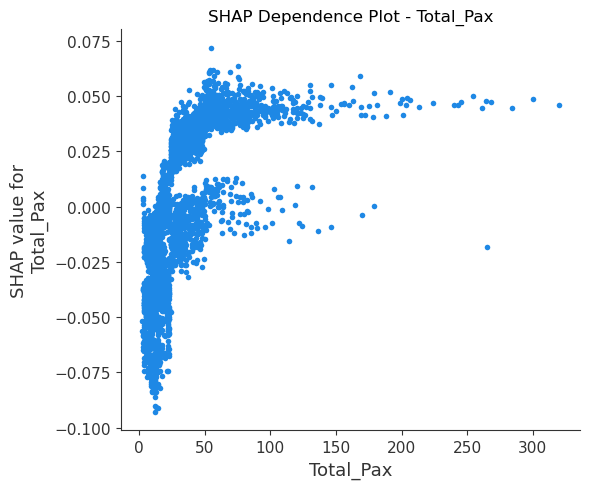

Plotting 3/10: FPP


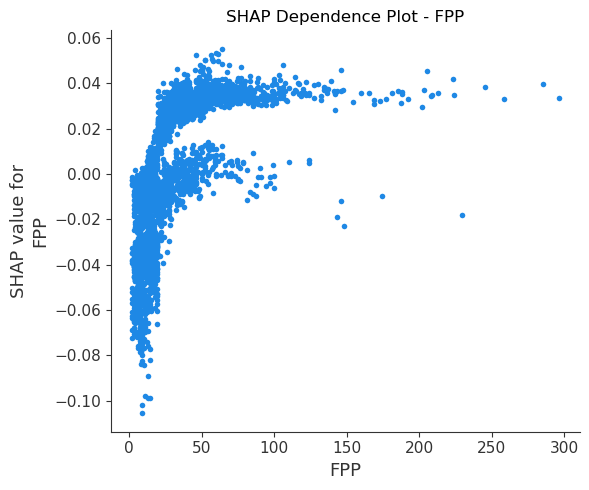

Plotting 4/10: Revenue_per_PAX


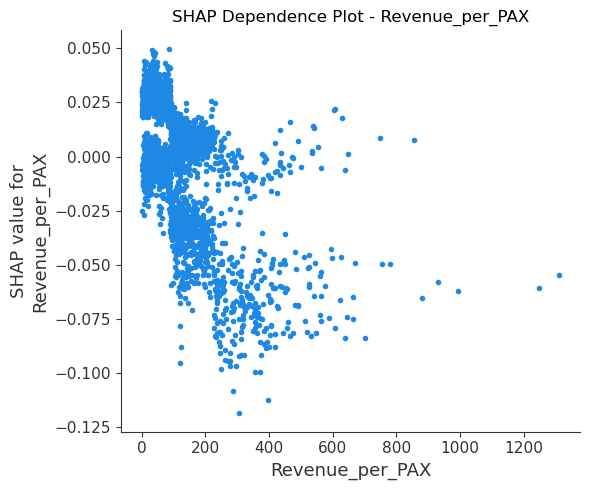

Plotting 5/10: Total_School_Enrollment


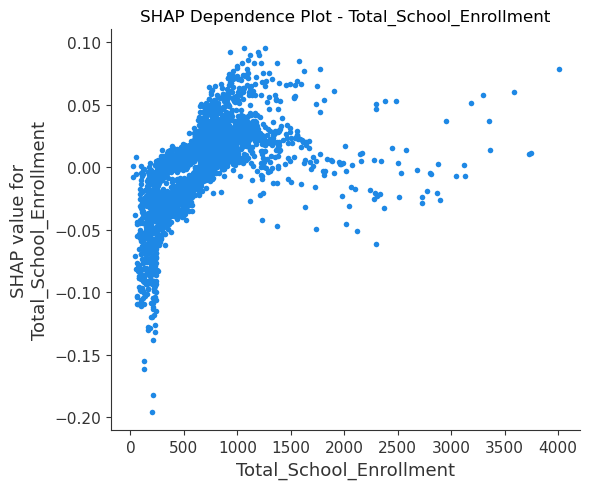

Plotting 6/10: FRP_Active


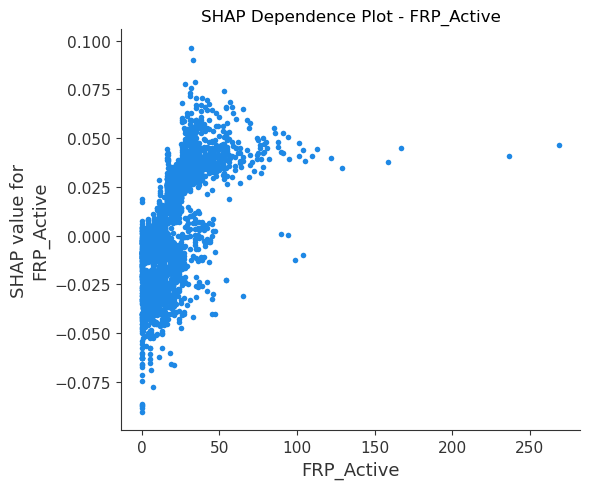

Plotting 7/10: Deposit_Ratio


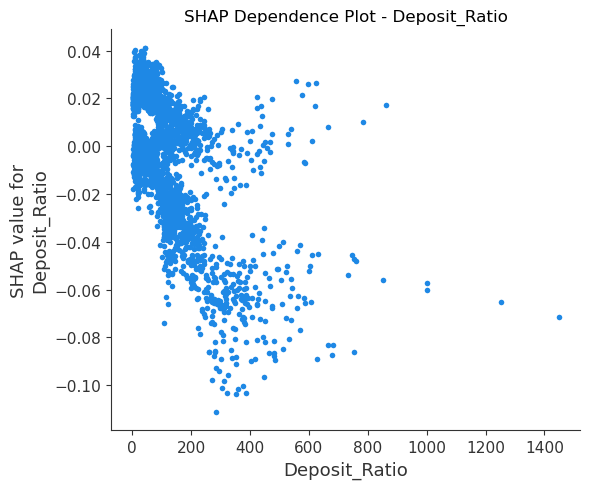

Plotting 8/10: Days_between_System_and_FirstMeeting


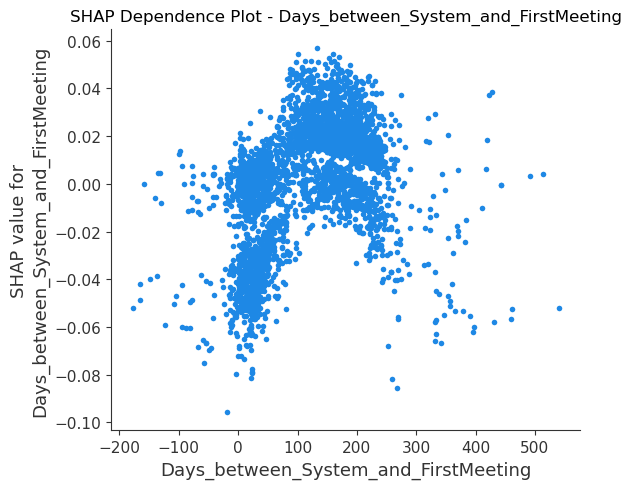

Plotting 9/10: FPP_to_School_enrollment


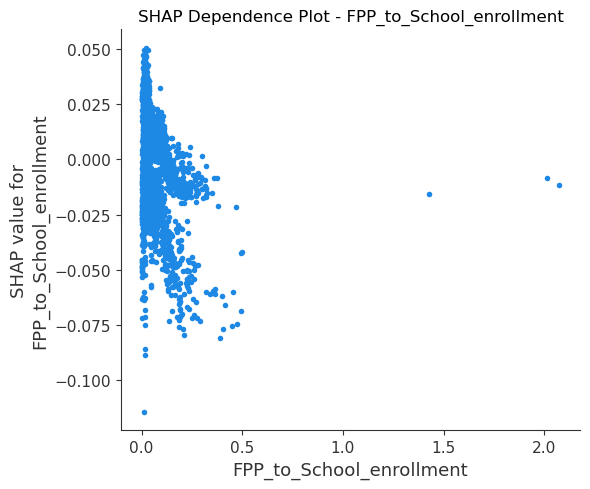

Plotting 10/10: Days_between_System_and_LastMeeting


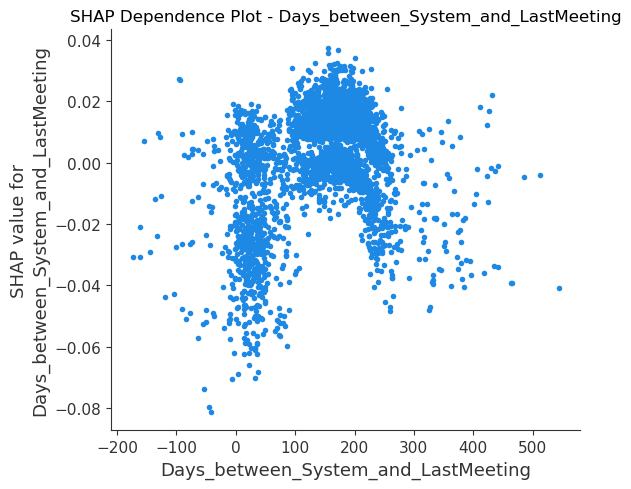

In [41]:
for i, feature_name in enumerate(top_10_features):
    print(f"Plotting {i+1}/10: {feature_name}")
    fig = shap.dependence_plot(
        feature_name,
        shap_class_1,
        X_train,
        feature_names=X_train.columns,
        interaction_index=None,  # ❌ No color by interaction
        show=False
    )
    plt.title(f"SHAP Dependence Plot - {feature_name}")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

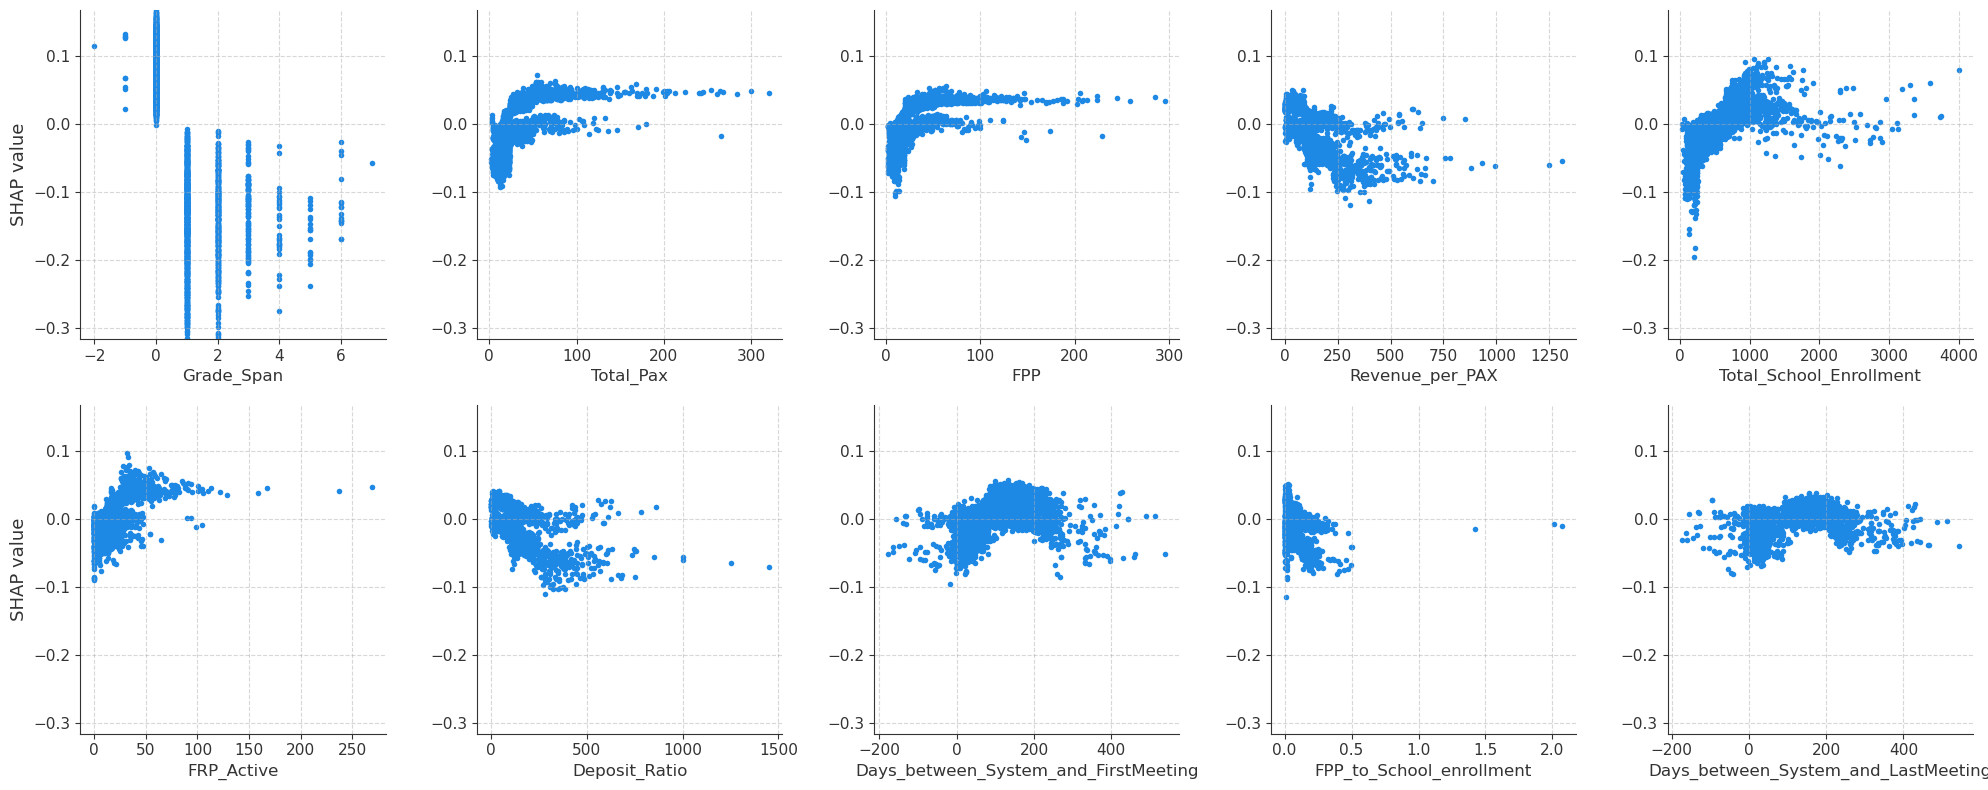

In [67]:
# Use SHAP values for the positive class
shap_class_1 = shap_values[:, :, 1]

# Get top 10 features by mean(|SHAP|):
mean_abs_shap = np.abs(shap_class_1).mean(axis=0)
top_10_indices = np.argsort(mean_abs_shap)[::-1][:10]
top_10_features = X_train.columns[top_10_indices]

# Get global SHAP value limits for consistent y-axis
shap_min = shap_class_1[:, top_10_indices].min()
shap_max = shap_class_1[:, top_10_indices].max()

# Create 2x5 grid of plots
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=True)
axes = axes.flatten()

for i, feature_name in enumerate(top_10_features):
    ax = axes[i]

    # Plot the SHAP dependence plot
    shap.dependence_plot(
        feature_name,
        shap_class_1,
        X_train,
        feature_names=X_train.columns,
        interaction_index=None,
        ax=ax,
        show=False
    )

    # Clean up axes
    ax.set_xlabel(feature_name, fontsize=12)  # Set feature name as x-axis label
    ax.set_title("")  # Remove title
    ax.set_ylim([shap_min, shap_max])
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i % 5 == 0:
        ax.set_ylabel("SHAP value")  # Label only first column
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.show()
